<a href="https://colab.research.google.com/github/dietadestina/AI4Jobs_program/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center>Deep Learning for Time Series Forecasting</center></h2>

<img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Store%20Item%20Demand%20Forecasting%20Challenge/time-series%20graph.png" width="800">

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, SimpleRNN, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Loading data

In [ ]:
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/refs/heads/main/ev_sales.csv')
train, test = train_test_split(ev_sales, test_size=0.2, random_state=42)

### Train set

In [ ]:
train.describe()

,Cat,Maker,Year,Value
count,10720.000000,10720.000000,10720.000000,10720.000000
mean,1.014272,583.503451,2019.509235,96.863713
std,0.645104,337.536666,2.876425,629.897370
min,0.000000,0.000000,2015.000000,0.000000
25%,1.000000,292.000000,2017.000000,0.000000
50%,1.000000,583.000000,2020.000000,0.000000
75%,1.000000,872.000000,2022.000000,6.000000
max,3.000000,1177.000000,2024.000000,21079.000000


In [ ]:
test.describe()

,Cat,Maker,Year,Value
count,2680.000000,2680.000000,2680.000000,2680.000000
mean,1.021269,582.183955,2019.463060,111.854851
std,0.636629,340.189138,2.856421,764.876289
min,0.000000,1.000000,2015.000000,0.000000
25%,1.000000,289.000000,2017.000000,0.000000
50%,1.000000,592.500000,2019.000000,0.000000
75%,1.000000,870.000000,2022.000000,5.000000
max,3.000000,1177.000000,2024.000000,24045.000000


In [ ]:
train

,Cat,Maker,Year,Value
1472,2,111,2016,0
9546,1,141,2022,7
7318,1,542,2020,72
5144,0,981,2018,0
9148,1,965,2021,0
...,...,...,...,...
11964,2,1087,2023,0
5191,1,1022,2018,0
5390,1,23,2019,0
860,1,742,2015,0


In [ ]:
test

,Cat,Maker,Year,Value
12989,1,803,2024,0
8494,1,400,2021,0
1261,1,1104,2015,0
10443,2,924,2022,0
11959,1,1082,2023,0
...,...,...,...,...
5572,0,183,2019,0
8178,0,115,2021,0
4339,1,279,2018,0
4352,1,289,2018,1


### Time period of the train dataset

In [ ]:
print('Min year from train set: %s' % train['Year'].min())
print('Max year from train set: %s' % train['Year'].max())

Min year from train set: 2015
Max year from train set: 2024


#### Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [ ]:
lag_size = (test['Year'].max() - train['Year'].max())
print('Max year from train set: %s' % train['Year'].max())
print('Max year from test set: %s' % test['Year'].max())
print('Forecast lag size', lag_size)

Max year from train set: 2024
Max year from test set: 2024
Forecast lag size 0


### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [ ]:
yearly_sales = train.groupby('Year', as_index=False)['Value'].sum()
maker_daily_sales = train.groupby(['Maker', 'Year'], as_index=False)['Value'].sum()
cat_daily_sales = train.groupby(['Cat', 'Year'], as_index=False)['Value'].sum()

### Overall Yearly sales

In [ ]:
yearly_sales_sc = go.Scatter(x=yearly_sales['Year'], y=yearly_sales['Value'])
layout = go.Layout(title='Yearly sales', xaxis=dict(title='Year'), yaxis=dict(title='Value'))
fig = go.Figure(data=[yearly_sales_sc], layout=layout)
iplot(fig)

### Yearly sales by maker

In [ ]:
maker_daily_sales_sc = []
for maker in maker_daily_sales['Maker'].unique():
    current_maker_daily_sales = maker_daily_sales[(maker_daily_sales['Maker'] == maker)]
    maker_daily_sales_sc.append(go.Scatter(x=current_maker_daily_sales['Year'], y=current_maker_daily_sales['Value'], name=('Maker %s' % maker)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Year'), yaxis=dict(title='Value'))
fig = go.Figure(data=maker_daily_sales_sc, layout=layout)
iplot(fig)

### Daily sales by item

In [ ]:
cat_daily_sales_sc = []
for cat in cat_daily_sales['Cat'].unique():
    current_cat_daily_sales = cat_daily_sales[(cat_daily_sales['Cat'] == cat)]
    cat_daily_sales_sc.append(go.Scatter(x=current_cat_daily_sales['Year'], y=current_cat_daily_sales['Value'], name=('Cat %s' % cat)))

layout = go.Layout(title='Category yearly sales', xaxis=dict(title='Year'), yaxis=dict(title='Value'))
fig = go.Figure(data=cat_daily_sales_sc, layout=layout)
iplot(fig)

#### Sub-sample train set to get only the last year of data and reduce training time

In [ ]:
train = train[(train['Year'] >= 2020)]

### Rearrange dataset so we can apply shift methods

In [ ]:
train_gp = train.sort_values('Year').groupby(['Cat', 'Maker', 'Year'], as_index=False)
train_gp = train_gp.agg({'Value':['mean']})
train_gp.columns = ['Cat', 'Maker', 'Year', 'Value']
train_gp.head()

,Cat,Maker,Year,Value
0,0,1,2020,0.0
1,0,1,2021,0.0
2,0,1,2022,0.0
3,0,1,2024,0.0
4,0,9,2022,0.0


### Transform the data into a time series problem

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('Year', axis=1), window=window, lag=lag)
series.head()

,Cat(t-29),Maker(t-29),Value(t-29),Cat(t-28),Maker(t-28),Value(t-28),Cat(t-27),Maker(t-27),Value(t-27),Cat(t-26),...,Value(t-2),Cat(t-1),Maker(t-1),Value(t-1),Cat(t),Maker(t),Value(t),Cat(t+0),Maker(t+0),Value(t+0)
29,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,67.0,0.0,53.0,14.0,0,61,1497.0,0,61,1497.0
30,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,14.0,0.0,61.0,1497.0,0,61,1574.0,0,61,1574.0
31,0.0,1.0,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,...,1497.0,0.0,61.0,1574.0,0,62,153.0,0,62,153.0
32,0.0,1.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,...,1574.0,0.0,62.0,153.0,0,62,315.0,0,62,315.0
33,0.0,9.0,0.0,0.0,9.0,0.0,0.0,25.0,0.0,0.0,...,153.0,0.0,62.0,315.0,0,62,2390.0,0,62,2390.0


#### Drop rows with different item or store values than the shifted columns

In [ ]:
#last_cat = 'Cat(t-%d)' % window
#last_maker = 'Maker(t-%d)' % window
#series = series[(series['Maker(t)'] == series[last_cat])]
#series = series[(series['Cat(t)'] == series[last_maker])]
#series

#### Remove unwanted columns

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Cat', 'Maker']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Cat', 'Maker']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['Cat(t)', 'Maker(t)'], axis=1, inplace=True)

In [ ]:
series

,Value(t-29),Value(t-28),Value(t-27),Value(t-26),Value(t-25),Value(t-24),Value(t-23),Value(t-22),Value(t-21),Value(t-20),...,Value(t-8),Value(t-7),Value(t-6),Value(t-5),Value(t-4),Value(t-3),Value(t-2),Value(t-1),Value(t),Value(t+0)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,67.0,14.0,1497.0,1497.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,48.0,...,1.0,0.0,0.0,0.0,0.0,67.0,14.0,1497.0,1574.0,1574.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,48.0,0.0,...,0.0,0.0,0.0,0.0,67.0,14.0,1497.0,1574.0,153.0,153.0
32,0.0,0.0,0.0,0.0,0.0,0.0,12.0,48.0,0.0,0.0,...,0.0,0.0,0.0,67.0,14.0,1497.0,1574.0,153.0,315.0,315.0
33,0.0,0.0,0.0,0.0,0.0,12.0,48.0,0.0,0.0,0.0,...,0.0,0.0,67.0,14.0,1497.0,1574.0,153.0,315.0,2390.0,2390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5362,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0
5363,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0
5364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0
5365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0


### Train/validation split

In [ ]:
# Label
labels_col = 'Value(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (3202, 30)
Validation set shape (2136, 30)


,Value(t-29),Value(t-28),Value(t-27),Value(t-26),Value(t-25),Value(t-24),Value(t-23),Value(t-22),Value(t-21),Value(t-20),...,Value(t-9),Value(t-8),Value(t-7),Value(t-6),Value(t-5),Value(t-4),Value(t-3),Value(t-2),Value(t-1),Value(t)
5094,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1758,428.0,610.0,934.0,444.0,9.0,0.0,0.0,0.0,17.0,0.0,...,495.0,0.0,0.0,0.0,0.0,0.0,448.0,1381.0,479.0,23.0
447,0.0,7.0,0.0,1.0,2.0,0.0,0.0,12.0,3.0,2.0,...,687.0,0.0,0.0,9.0,52.0,37.0,0.0,37.0,102.0,0.0
717,0.0,25.0,2371.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,1.0,60.0,143.0,68.0,0.0,0.0,0.0,0.0
1017,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,112.0,...,68.0,266.0,578.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
epochs = 50
batch = 32

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (3202, 30, 1)
Validation set shape (2136, 30, 1)


### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 100)                 │           3,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
101/101 - 2s - 15ms/step - loss: 892614.1250 - val_loss: 533557.8750
Epoch 2/50
101/101 - 1s - 6ms/step - loss: 600693.3125 - val_loss: 377799.6875
Epoch 3/50
101/101 - 1s - 7ms/step - loss: 421775.0312 - val_loss: 273514.8438
Epoch 4/50
101/101 - 0s - 5ms/step - loss: 299892.7188 - val_loss: 200349.4219
Epoch 5/50
101/101 - 0s - 3ms/step - loss: 210162.9688 - val_loss: 161007.0625
Epoch 6/50
101/101 - 0s - 3ms/step - loss: 147797.2344 - val_loss: 125873.8438
Epoch 7/50
101/101 - 0s - 3ms/step - loss: 102719.6406 - val_loss: 103972.9375
Epoch 8/50
101/101 - 0s - 3ms/step - loss: 72652.5391 - val_loss: 84875.0234
Epoch 9/50
101/101 - 0s - 3ms/step - loss: 52790.6367 - val_loss: 71129.6953
Epoch 10/50
101/101 - 0s - 3ms/step - loss: 39408.2188 - val_loss: 60352.8633
Epoch 11/50
101/101 - 0s - 2ms/step - loss: 29416.2832 - val_loss: 51886.1250
Epoch 12/50
101/101 - 0s - 3ms/step - loss: 22332.4570 - val_loss: 44545.2578
Epoch 13/50
101/101 - 0s - 3ms/step - loss: 17617.2578 - v

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))

model_cnn.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 29, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,093 (176.14 KB)

 Trainable params: 45,093 (176.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
101/101 - 2s - 20ms/step - loss: 851025.3750 - val_loss: 533654.4375
Epoch 2/50
101/101 - 0s - 4ms/step - loss: 785065.4375 - val_loss: 535675.6250
Epoch 3/50
101/101 - 1s - 6ms/step - loss: 749217.1875 - val_loss: 517143.0000
Epoch 4/50
101/101 - 0s - 4ms/step - loss: 711828.1250 - val_loss: 529847.1875
Epoch 5/50
101/101 - 1s - 6ms/step - loss: 692027.6250 - val_loss: 512636.0312
Epoch 6/50
101/101 - 1s - 6ms/step - loss: 661091.7500 - val_loss: 530192.1875
Epoch 7/50
101/101 - 0s - 4ms/step - loss: 648320.2500 - val_loss: 518745.9375
Epoch 8/50
101/101 - 0s - 5ms/step - loss: 623174.3125 - val_loss: 528816.6875
Epoch 9/50
101/101 - 0s - 3ms/step - loss: 609681.8750 - val_loss: 531373.8125
Epoch 10/50
101/101 - 0s - 3ms/step - loss: 587698.5000 - val_loss: 538921.3750
Epoch 11/50
101/101 - 0s - 3ms/step - loss: 580430.0625 - val_loss: 546598.5625
Epoch 12/50
101/101 - 0s - 3ms/step - loss: 565600.7500 - val_loss: 545059.5625
Epoch 13/50
101/101 - 0s - 2ms/step - loss: 5560

### RNN for Time Series Forecasting

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_rnn.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_rnn.compile(loss='mse', optimizer=adam)
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_history = model_rnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
101/101 - 3s - 30ms/step - loss: 1605203.2500 - val_loss: 879244.1250
Epoch 2/50
101/101 - 1s - 13ms/step - loss: 1255287.5000 - val_loss: 678362.6875
Epoch 3/50
101/101 - 1s - 10ms/step - loss: 957360.4375 - val_loss: 468401.9062
Epoch 4/50
101/101 - 1s - 5ms/step - loss: 631318.1250 - val_loss: 371490.8438
Epoch 5/50
101/101 - 1s - 5ms/step - loss: 489724.2500 - val_loss: 317051.2812
Epoch 6/50
101/101 - 1s - 7ms/step - loss: 374924.4062 - val_loss: 247897.1406
Epoch 7/50
101/101 - 1s - 6ms/step - loss: 296160.3125 - val_loss: 243888.2188
Epoch 8/50
101/101 - 1s - 6ms/step - loss: 275960.1562 - val_loss: 151072.2969
Epoch 9/50
101/101 - 1s - 11ms/step - loss: 202872.5625 - val_loss: 246270.2969
Epoch 10/50
101/101 - 1s - 6ms/step - loss: 167584.8750 - val_loss: 88792.2266
Epoch 11/50
101/101 - 1s - 6ms/step - loss: 171424.1406 - val_loss: 177044.5469
Epoch 12/50
101/101 - 1s - 5ms/step - loss: 135813.3281 - val_loss: 76132.4062
Epoch 13/50
101/101 - 1s - 6ms/step - loss: 8

### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
101/101 - 4s - 38ms/step - loss: 1341709.2500 - val_loss: 899040.5000
Epoch 2/50
101/101 - 1s - 8ms/step - loss: 1278263.7500 - val_loss: 890143.6875
Epoch 3/50
101/101 - 1s - 5ms/step - loss: 1243029.8750 - val_loss: 869285.5000
Epoch 4/50
101/101 - 1s - 5ms/step - loss: 1257334.5000 - val_loss: 846295.8750
Epoch 5/50
101/101 - 1s - 6ms/step - loss: 1226496.1250 - val_loss: 831884.1875
Epoch 6/50
101/101 - 1s - 6ms/step - loss: 1200052.8750 - val_loss: 809296.3750
Epoch 7/50
101/101 - 0s - 5ms/step - loss: 1181056.3750 - val_loss: 794346.9375
Epoch 8/50
101/101 - 1s - 8ms/step - loss: 1163302.8750 - val_loss: 769800.0000
Epoch 9/50
101/101 - 1s - 12ms/step - loss: 1138461.3750 - val_loss: 756661.0625
Epoch 10/50
101/101 - 1s - 8ms/step - loss: 1109400.7500 - val_loss: 736366.9375
Epoch 11/50
101/101 - 1s - 10ms/step - loss: 1076539.2500 - val_loss: 713997.7500
Epoch 12/50
101/101 - 1s - 6ms/step - loss: 1059664.8750 - val_loss: 710183.7500
Epoch 13/50
101/101 - 1s - 5ms/ste

### Comparing models

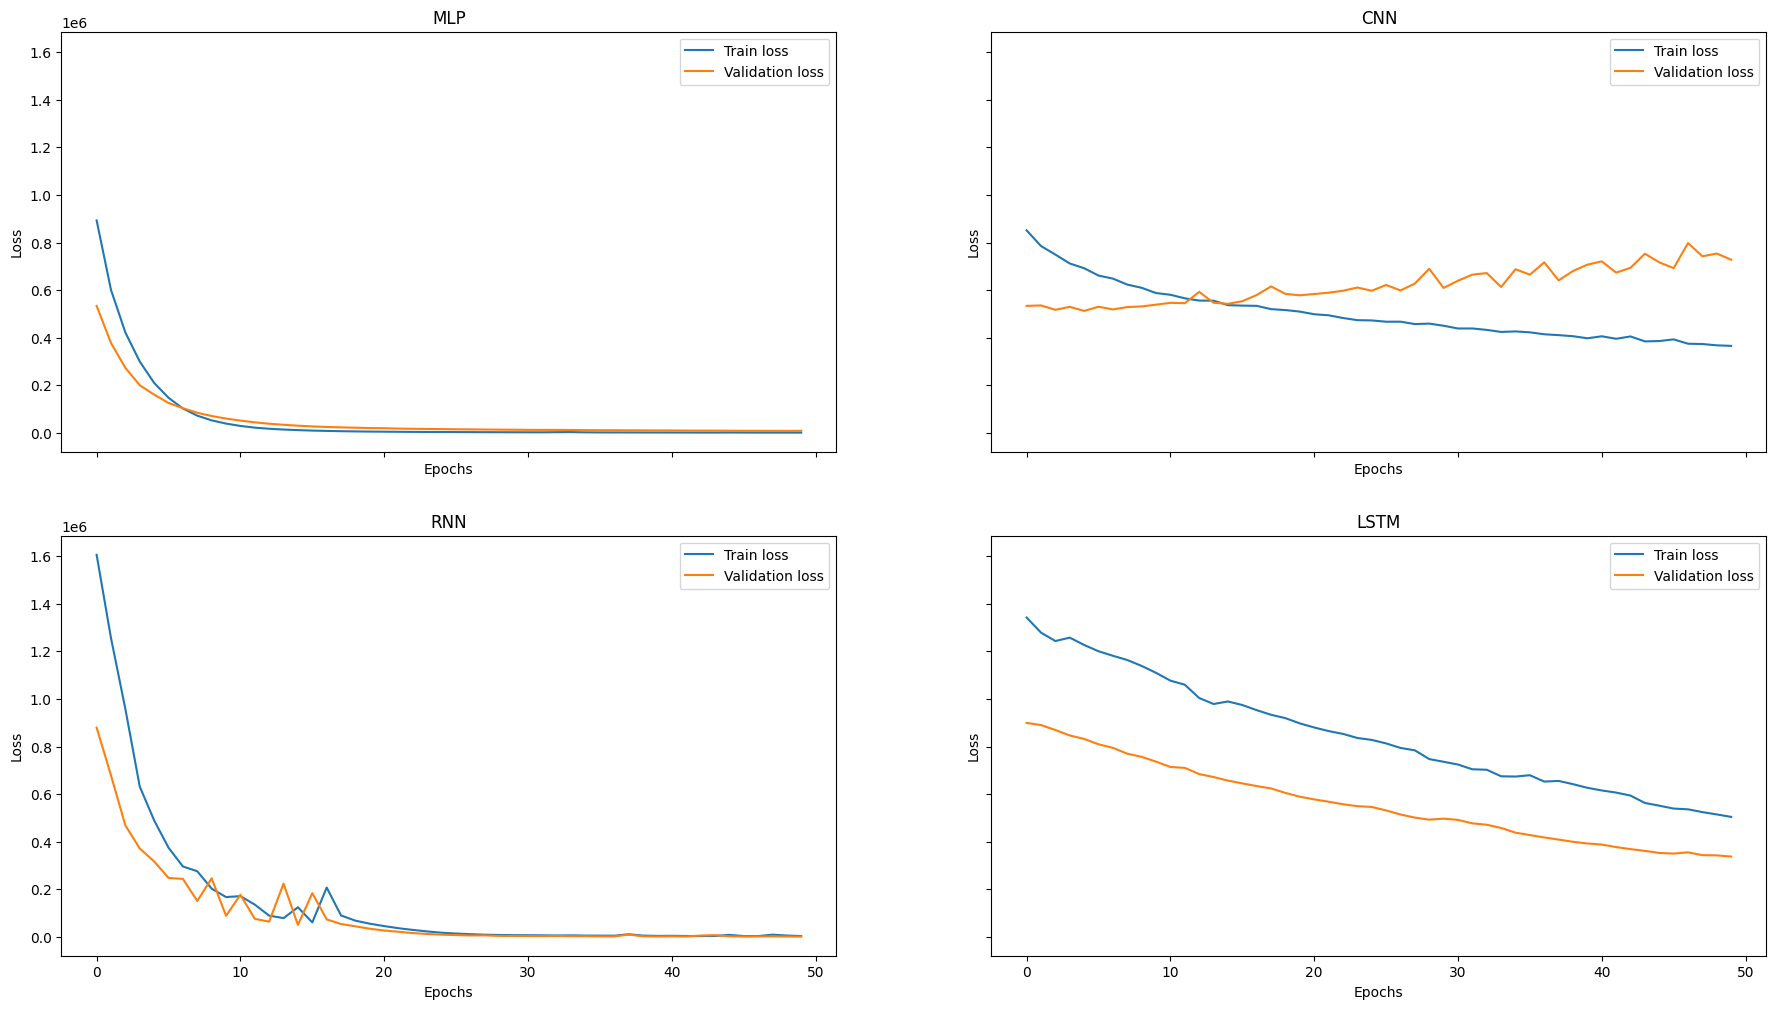

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(rnn_history.history['loss'], label='Train loss')
ax3.plot(rnn_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('RNN')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')

ax4.plot(lstm_history.history['loss'], label='Train loss')
ax4.plot(lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')

plt.show()